In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
from glob import glob
from pathlib import Path
import face_alignment

ModuleNotFoundError: No module named 'face_alignment'

In [ ]:


# Load pretrained landmark model (68 points, 2D)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [12]:

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D, device=device, flip_input=False)


In [13]:
def create_nose_mask(image_path, save_path, log):
    try:
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        preds = fa.get_landmarks(img_rgb)
        if preds is None:
            return False
            
    except Warning as w:  # Catch warnings as exceptions
        return False

    landmarks = preds[0]
    nose_points = landmarks[27:36]  # indexes 27–35 in 0-based Python index

    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(nose_points), 255)

    cv2.imwrite(save_path, mask)
    return True

In [14]:
import os
import warnings
import logging

def batch_create_nose_masks(src_dir, dst_dir, create_func, exts=('.jpg','.jpeg','.png')):
    """
    Generate nose masks for all images in src_dir and save in dst_dir.
    Skips files if the mask already exists.
    """
    os.makedirs(dst_dir, exist_ok=True)
    warnings.filterwarnings("error", message="No faces were detected.")

    for file in os.listdir(src_dir):
        if file.lower().endswith(exts):
            in_path  = os.path.join(src_dir, file)
            out_path = os.path.join(dst_dir, file)
            if not os.path.exists(out_path):
                try:
                    create_func(in_path, out_path, logging)
                except Warning as w:
                    logging.warning(f"Skipped {file}: {w}")
                except Exception as e:
                    logging.error(f"Error with {file}: {e}")

base_dir = "/workspace/data_splits"
splits = ["train", "val", "test"]

for split in splits:
    input_folder = os.path.join(base_dir, split, "input")
    mask_folder  = os.path.join(base_dir, split, "mask_input")
    batch_create_nose_masks(input_folder, mask_folder, create_nose_mask)

In [15]:
from pathlib import Path

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

def _map_stem_to_name(dir_path: Path):
    """Return {stem: filename} for allowed image files (first match per stem)."""
    m = {}
    for p in dir_path.iterdir():
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            m.setdefault(p.stem, p.name)  # keep first occurrence
    return m

def validate_files(img_dir, mask_dir, target_dir, verbose=True):
    img_dir, mask_dir, target_dir = map(Path, (img_dir, mask_dir, target_dir))

    img_map    = _map_stem_to_name(img_dir)
    mask_map   = _map_stem_to_name(mask_dir)
    target_map = _map_stem_to_name(target_dir)

    img_stems    = set(img_map.keys())
    mask_stems   = set(mask_map.keys())
    target_stems = set(target_map.keys())

    common = sorted(img_stems & mask_stems & target_stems)

    missing_mask   = sorted(img_stems - mask_stems)
    missing_target = sorted(img_stems - target_stems)
    orphan_masks   = sorted(mask_stems - img_stems)
    orphan_targets = sorted(target_stems - img_stems)

    if verbose:
        print(f"[validate] counts: img={len(img_stems)} mask={len(mask_stems)} target={len(target_stems)}")
        print(f"[validate] common triples: {len(common)}")
        if missing_mask:   print(f"[validate] missing masks for {len(missing_mask)} imgs, e.g. {missing_mask[:5]}")
        if missing_target: print(f"[validate] missing targets for {len(missing_target)} imgs, e.g. {missing_target[:5]}")
        if orphan_masks:   print(f"[validate] masks without imgs: {len(orphan_masks)}, e.g. {orphan_masks[:5]}")
        if orphan_targets: print(f"[validate] targets without imgs: {len(orphan_targets)}, e.g. {orphan_targets[:5]}")

    # Build (img_filename, target_filename) using the exact filenames found
    pairs = [(img_map[s], target_map[s]) for s in common]

    if len(pairs) == 0:
        raise ValueError(
            "No valid (img, mask, target) triples found.\n"
            f"Checked:\n  img_dir={img_dir}\n  mask_dir={mask_dir}\n  target_dir={target_dir}\n"
            "See [validate] logs above for mismatches."
        )
    return pairs

In [16]:
import torch
import torch.nn.functional as F

def collate_keep_aspect(batch, multiple=32):
    """
    Batch collate that keeps aspect ratios.
    Pads all images/masks/targets in the batch to the max H and W,
    rounded up to the nearest multiple.
    """
    imgs, tgts, masks, orig_hw, files = [], [], [], [], []

    for b in batch:
        x = b["input"]    # [3,H,W]
        y = b["target"]   # [3,H,W]
        m = b["mask"]     # [1,H,W]
        H, W = x.shape[1:]

        imgs.append(x)
        tgts.append(y)
        masks.append(m)
        orig_hw.append(torch.tensor([H, W], dtype=torch.int32))
        files.append((b.get("input_file",""), b.get("mask_file",""), b.get("target_file","")))

    # find max height/width in this batch
    Ht = max(t.shape[1] for t in imgs)
    Wt = max(t.shape[2] for t in imgs)

    # round up to nearest multiple (stride)
    Ht = (Ht + multiple - 1) // multiple * multiple
    Wt = (Wt + multiple - 1) // multiple * multiple

    def pad_to(t, Ht, Wt):
        # pad as (left, right, top, bottom)
        return F.pad(t, (0, Wt - t.shape[2], 0, Ht - t.shape[1]))

    X = torch.stack([pad_to(t, Ht, Wt) for t in imgs])
    Y = torch.stack([pad_to(t, Ht, Wt) for t in tgts])
    M = torch.stack([pad_to(t, Ht, Wt) for t in masks])
    OHW = torch.stack(orig_hw)

    return {
        "input": X,     # [B,3,Ht,Wt]
        "target": Y,    # [B,3,Ht,Wt]
        "mask": M,      # [B,1,Ht,Wt]
        "orig_hw": OHW, # [B,2]
        "files": files
    }

In [17]:
from pathlib import Path
from torch.utils.data import Dataset
import torch, cv2
import numpy as np

class NoseFolderDataset(Dataset):
    def __init__(self, img_dir, mask_dir, target_dir, size=256):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.target_dir = Path(target_dir)
        self.file_pairs = validate_files(self.img_dir, self.mask_dir, self.target_dir)   # [(img_name, tgt_name), ...]

    def __len__(self):
        return len(self.file_pairs)

    def _read_rgb(self, path):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        # (H,W,3) uint8
        return img

    def _read_mask(self, path):
        
        m = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(path)
        m = (m > 127).astype(np.uint8)                    # (H,W) 0/1
        return m

    def __getitem__(self, idx):
        fname, target_f = self.file_pairs[idx]
        ip, mp, tp = self.img_dir/fname, self.mask_dir/fname, self.target_dir/target_f

        img    = self._read_rgb(ip)     # H,W,3
        target = self._read_rgb(tp)     # H,W,3
        mask   = self._read_mask(mp)    # H,W

        if img.shape[:2] != target.shape[:2]:
            # minimal: resize target to img (or vice-versa, pick one consistently)
            target = cv2.resize(target, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_AREA)
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

        H, W = img.shape[:2]
        img_t  = torch.from_numpy(img).permute(2,0,1).float()/255.0
        tgt_t  = torch.from_numpy(target).permute(2,0,1).float()/255.0
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()

        return {
            "input": img_t, "target": tgt_t, "mask": mask_t,
            "orig_h": H, "orig_w": W,
            "input_file": str(ip), "mask_file": str(mp), "target_file": str(tp),
        }

In [18]:
# --------------------------- Generator (UnE) ----------

import torch
import torch.nn as nn
import torch.nn.functional as F

# ----- tiny mask helpers
def dilate_mask_binary(mask, k=11, iters=2):
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out.clamp(0,1)

def feather_mask(mask, k=9):
    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)


# --------------------------- UNet blocks ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.InstanceNorm2d(out_ch, affine=True),
            nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # pad if needed (in case odd dims)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        if diffY != 0 or diffX != 0:
            x = F.pad(x, (0, diffX, 0, diffY))
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


# --------------------------- UNet Generator (residual) ---------------------------
class UNetNoseGenerator(nn.Module):
    """
    UNet that takes RGB+mask (4ch) and predicts a 3ch residual 'delta'.
    Output = rgb + soft_mask * tanh(raw) * scale
    """
    def __init__(self, in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75):
        """
        depth=5 -> downsample x2 five times (stride 32). Use collate multiple=32.
        For less memory, set depth=4 (stride 16).
        """
        super().__init__()
        self.out_ch = out_ch
        self.res_max = res_max

        # encoder
        self.inc  = ConvBlock(in_ch, base)                 # H
        self.down1 = Down(base,     base*2)                # H/2
        self.down2 = Down(base*2,   base*4)                # H/4
        self.down3 = Down(base*4,   base*8)                # H/8
        self.down4 = Down(base*8,   base*8)                # H/16
        self.has_down5 = (depth >= 5)
        if self.has_down5:
            self.down5 = Down(base*8, base*8)              # H/32

        # decoder
        if self.has_down5:
            self.up1 = Up(base*8 + base*8, base*8)         # concat with down4
            ch_up_in = base*8 + base*8
        else:
            # if no down5, first up will concatenate down3 and bottleneck at base*8
            ch_up_in = base*8 + base*8  # consistent with next lines

        self.up2 = Up(base*8 + base*8, base*8)             # + down3
        self.up3 = Up(base*8 + base*4, base*4)             # + down2
        self.up4 = Up(base*4 + base*2, base*2)             # + down1
        self.up5 = Up(base*2 + base,   base)               # + inc

        self.outc = nn.Conv2d(base, out_ch, kernel_size=3, padding=1)
        nn.init.zeros_(self.outc.weight)
        nn.init.zeros_(self.outc.bias)

        # learnable residual cap
        self._alpha = nn.Parameter(torch.tensor(0.0))  # sigmoid ~0.5 initially

    def forward(self, inp, return_full=False):
        """
        inp: [B,4,H,W]  (RGB + binary/soft mask in channel 4)
        returns: [B,3,H,W] blended output at original size
        """
        rgb   = inp[:, :3]
        mask1 = inp[:, 3:4]

        # encoder
        x1 = self.inc(inp)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        if self.has_down5:
            x6 = self.down5(x5)
            u1 = self.up1(x6, x5)
        else:
            u1 = self.up2(x5, x4)  # skip one level if depth=4

        # decoder path
        if self.has_down5:
            u2 = self.up2(u1, x4)
        else:
            u2 = u1
        u3 = self.up3(u2, x3)
        u4 = self.up4(u3, x2)
        u5 = self.up5(u4, x1)

        raw   = self.outc(u5)               # [B,3,H,W]
        scale = torch.sigmoid(self._alpha) * self.res_max
        delta = torch.tanh(raw) * scale     # bounded residual

        # soft blend within a feathered mask band
        hard   = dilate_mask_binary(mask1, k=11, iters=2)
        m_soft = feather_mask(hard, k=9)            # [B,1,H,W]
        m3     = m_soft.repeat(1, 3, 1, 1)
        full_rgb = (rgb + delta)
        out    = rgb + delta * m3
        if return_full:
            return out, full_rgb, m_soft
        return out



In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class VGGPerceptualLoss(nn.Module):
    """
    VGG16 feature L1 loss. Works on inputs in [0,1].
    If mask is given (B,1,H,W), it is downsampled per VGG stage and used
    to weight the feature differences spatially.
    """
    def __init__(self, layers=(3, 8, 15, 22), layer_weights=None):
        super().__init__()
        # relu1_2=3, relu2_2=8, relu3_3=15, relu4_3=22 in torchvision VGG16.features
        self.layers = tuple(layers)
        self.layer_weights = (
            [1.0] * len(self.layers) if layer_weights is None else layer_weights
        )

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.vgg = vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad_(False)

        # register mean/std buffers for ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.register_buffer('mean', mean, persistent=False)
        self.register_buffer('std',  std,  persistent=False)

    def _norm(self, x):
        # x expected in [0,1]
        return (x - self.mean) / self.std

    def forward(self, pred, target, mask=None):
        """
        pred, target: (B,3,H,W) in [0,1]
        mask (optional): (B,1,H,W) with 0..1 weights (e.g., your nose mask)
        """
        x = self._norm(pred)
        y = self._norm(target)

        loss = 0.0
        idx_set = set(self.layers)
        lw_iter = iter(self.layer_weights)

        # run through the VGG and collect selected layers
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)

            if i in idx_set:
                w = next(lw_iter)
                if mask is None:
                    # plain feature L1
                    loss += w * F.l1_loss(x, y)
                else:
                    # masked feature L1 (downsample mask to feature size)
                    m = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
                    num = (m * (x - y).abs()).sum()
                    den = m.sum() + 1e-6
                    loss += w * (num / den)

        return loss

In [22]:
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
def dilate_mask_binary(mask, k=11, iters=2):
    """Binary dilation. mask: (B,1,H,W) in {0,1} float."""
    out = mask
    for _ in range(iters):
        out = F.max_pool2d(out, kernel_size=k, stride=1, padding=k//2)
    return out.clamp(0,1)

def erode_mask_binary(mask, k=11, iters=1):
    """Binary erosion via max-pool trick."""
    x = 1.0 - mask
    for _ in range(iters):
        x = F.max_pool2d(x, kernel_size=k, stride=1, padding=k//2)
    return (1.0 - x).clamp(0,1)

def feather_mask(mask, k=9):
    """Soft edge (0..1) via avg-pool (feathered band)."""
    return F.avg_pool2d(mask, kernel_size=k, stride=1, padding=k//2).clamp(0,1)

# ---------- patch mask helper ----------
def mask_to_patch_mask(mask, patch_size):
    """
    Convert (B,1,H,W) 0/1 (or soft) mask to (B, N) patch weights by
    averaging within non-overlapping p×p patches.
    """
    B, _, H, W = mask.shape
    p = patch_size
    # trim if H/W not divisible by p
    Ht, Wt = (H // p) * p, (W // p) * p
    m = mask[:, :, :Ht, :Wt]
    # (B,1, H/p, p, W/p, p) -> mean over the two 'p' dims -> (B,1,H/p,W/p)
    m = m.view(B, 1, Ht//p, p, Wt//p, p).mean(dim=(3,5))
    return m.flatten(1)  # (B, N)

# ---------- simple PatchGAN (1-channel real/fake map) ----------
class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=6, base=64):
        super().__init__()
        c = base
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   c, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c,     c*2, 4, 2, 1), nn.BatchNorm2d(c*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*2,   c*4, 4, 2, 1), nn.BatchNorm2d(c*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*4,   c*8, 4, 2, 1), nn.BatchNorm2d(c*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c*8,     1, 4, 1, 1)
        )
    def forward(self, x): return self.net(x)



import os, torch, torch.nn as nn, torch.nn.functional as F
from tqdm import tqdm
import piq
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# ---------- helpers ----------
def crop_to_mask_bbox(t: torch.Tensor, m: torch.Tensor, thresh: float = 0.05, dilate_px: int = 0):
    """
    t: [B,C,H,W], m: [B,1,H,W] in [0,1]; returns batch of crops stacked.
    We find a tight bbox of (m>thresh). Optionally dilate bbox by 'dilate_px'.
    If mask is empty, fall back to full image for that item.
    """
    B, _, H, W = t.shape
    crops = []
    for b in range(B):
        mb = m[b, 0]
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            crops.append(t[b:b+1])
            continue
        y0, y1 = yy.min().item(), yy.max().item() + 1
        x0, x1 = xx.min().item(), xx.max().item() + 1
        if dilate_px > 0:
            y0 = max(0, y0 - dilate_px); x0 = max(0, x0 - dilate_px)
            y1 = min(H, y1 + dilate_px); x1 = min(W, x1 + dilate_px)
        crops.append(t[b:b+1, :, y0:y1, x0:x1])
    return torch.cat(crops, dim=0)

@torch.no_grad()
def validate_epoch(G, loader, device, ssim_metric):
    G.eval()
    tot_l1m, tot_ssim_global, tot_ssim_mask, n = 0.0, 0.0, 0.0, 0
    for batch in loader:
        rgb    = batch["input"].to(device)   # [B,3,H,W]  in [0,1]
        target = batch["target"].to(device)  # [B,3,H,W]
        mask   = batch["mask"].to(device)    # [B,1,H,W]
        inp    = torch.cat([rgb, mask], dim=1)

        hard   = dilate_mask_binary(mask, k=11, iters=2)
        m_soft = feather_mask(hard, k=9)

        pred = G(inp)  # final blended output

        # L1 over mask
        l1m = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)

        # SSIM(global) and SSIM(mask) with torchmetrics (eval only)
        ssim_global = ssim_metric(pred, target)
        ssim_masked = ssim_metric(pred * m_soft, target * m_soft)

        b = inp.size(0)
        tot_l1m        += l1m.item() * b
        tot_ssim_global += ssim_global.item() * b
        tot_ssim_mask  += ssim_masked.item() * b
        n += b

    return (tot_l1m / max(1, n),
            tot_ssim_global / max(1, n),
            tot_ssim_mask / max(1, n))

def ssim_loss_on_bbox(pred, target, m_soft, *, use_ms=False, data_range=1.0, thresh=0.05, dilate_px=4):
    B, C, H, W = pred.shape
    losses = []
    for b in range(B):
        mb = m_soft[b, 0]
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            pb, tb = pred[b:b+1], target[b:b+1]
        else:
            y0, y1 = yy.min().item(), yy.max().item()+1
            x0, x1 = xx.min().item(), xx.max().item()+1
            if dilate_px > 0:
                y0 = max(0, y0 - dilate_px); x0 = max(0, x0 - dilate_px)
                y1 = min(H, y1 + dilate_px); x1 = min(W, x1 + dilate_px)
            pb = pred[b:b+1, :, y0:y1, x0:x1]
            tb = target[b:b+1, :, y0:y1, x0:x1]

        # Clamp *only* for SSIM computation
        pb = pb.clamp(0.0, 1.0)
        tb = tb.clamp(0.0, 1.0)

        ssim_fn = piq.ms_ssim if use_ms else piq.ssim
        ssim_b = 1.0 - ssim_fn(pb, tb, data_range=1.0)
        losses.append(ssim_b)
    return torch.stack(losses).mean() if losses else torch.tensor(0.0, device=pred.device)

    
# ---------- training ----------
def train_gan(
    train_loader, val_loader, *,
    epochs=20, out_dir="ckpts_gan",
    lr_G=2e-4, lr_D=1e-4,
    adv_start_w=0.05,
    lambda_l1=5.0, lambda_out_id=0.5,
    use_perc=False, perceptual_fn=None,
    use_ssim_loss=True,          # <--- enable differentiable SSIM loss
    use_ms_ssim=False,           # <--- switch to MS-SSIM if you prefer
    lambda_ssim=0.1,             # <--- weight for SSIM/MS-SSIM loss (start small: 0.05-0.2)
    amp=True, device="cuda",
    resume_from=None
):
    """
    Training with:
      - L1(mask)
      - identity outside mask
      - GAN loss (hinge)
      - optional perceptual loss
      - optional (MS-)SSIM loss on nose ROI (bbox crop), differentiable via piq
    Validation logs: L1(mask), SSIM(global), SSIM(mask)
    Assumes images in [0,1]; if not, map before losses/metrics.
    """
    os.makedirs(out_dir, exist_ok=True)

    # ----- build models -----
    G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device)
    D = PatchDiscriminator(in_ch=6, base=64).to(device)

    # ----- opt -----
    opt_G = torch.optim.AdamW(G.parameters(), lr=lr_G, betas=(0.5, 0.999))
    opt_D = torch.optim.AdamW(D.parameters(), lr=lr_D, betas=(0.5, 0.999))

    # ----- (optional) resume -----
    start_ep = 1
    best = float("inf")
    if resume_from and os.path.isfile(resume_from):
        ckpt = torch.load(resume_from, map_location=device)
        G.load_state_dict(ckpt["G"], strict=True)
        D.load_state_dict(ckpt["D"], strict=True)
        if "opt_G" in ckpt: opt_G.load_state_dict(ckpt["opt_G"])
        if "opt_D" in ckpt: opt_D.load_state_dict(ckpt["opt_D"])
        start_ep = int(ckpt.get("epoch", 0)) + 1
        best = float(ckpt.get("val_l1m", best))
        print(f"[resume] from {resume_from} → start_ep={start_ep}  best={best:.4f}")
    else:
        if resume_from:
            print(f"[resume] file not found: {resume_from} (starting fresh)")

    # ----- schedulers -----
    sch_G = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_G, T_max=epochs, eta_min=lr_G*0.1, last_epoch=start_ep-2
    )
    sch_D = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt_D, T_max=epochs, eta_min=lr_D*0.1, last_epoch=start_ep-2
    )

    scaler_G = torch.amp.GradScaler('cuda', enabled=amp)
    scaler_D = torch.amp.GradScaler('cuda', enabled=amp)

    # ----- metrics (eval only) -----
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    best_path = None

    for ep in range(start_ep, epochs+1):
        G.train(); D.train()
        pbar = tqdm(train_loader, desc=f"train {ep}/{epochs}")
        adv_w = adv_start_w * min(1.0, ep/5.0)

        for batch in pbar:
            rgb    = batch["input"].to(device)   # (B,3,H,W) in [0,1]
            target = batch["target"].to(device)  # (B,3,H,W)
            mask   = batch["mask"].to(device)    # (B,1,H,W)
            inp    = torch.cat([rgb, mask], dim=1)

            hard    = dilate_mask_binary(mask, k=11, iters=2)
            m_soft  = feather_mask(hard, k=9)
            outside = 1.0 - erode_mask_binary(hard, k=11, iters=2)

            # ---- D step ----
            opt_D.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                with torch.no_grad():
                    fake = G(inp)
                real_logits = D(torch.cat([rgb, target], dim=1))
                fake_logits = D(torch.cat([rgb, fake],   dim=1))
                # Hinge loss
                d_loss = torch.relu(1. - real_logits).mean() + torch.relu(1. + fake_logits).mean()
            scaler_D.scale(d_loss).backward()
            scaler_D.step(opt_D)
            scaler_D.update()

            # ---- G step ----
            opt_G.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=amp):
                pred = G(inp)

                # Reconstruction losses
                l1_mask  = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
                l_out_id = ((pred - rgb).abs()    * outside).sum() / (outside.sum() + 1e-6)

                # GAN loss
                fake_logits_g = D(torch.cat([rgb, pred], dim=1))
                adv_loss = -fake_logits_g.mean()

                # Optional perceptual loss
                perc_loss = perceptual_fn(pred, target, mask=m_soft) if (use_perc and perceptual_fn) else 0.0

                # (MS-)SSIM loss on ROI (bbox around mask) using piq (differentiable)
                if use_ssim_loss:
                    # widen bbox a bit to include context
                    ssim_loss = ssim_loss_on_bbox(pred, target, m_soft,use_ms=use_ms_ssim, data_range=1.0, thresh=0.05, dilate_px=4
                                                )

                    
                else:
                    ssim_loss = 0.0

                g_loss = (lambda_l1 * l1_mask
                          + lambda_out_id * l_out_id
                          + adv_w * adv_loss
                          + 0.2 * (perceptual_fn(pred, target, mask=m_soft) if (use_perc and perceptual_fn) else 0.0)
                          + lambda_ssim * ssim_loss)
            scaler_G.scale(g_loss).backward()
            scaler_G.step(opt_G)
            scaler_G.update()

            # quick masked SSIM log (eval metric; no grads)
            with torch.no_grad():
                ssim_mask_step = ssim_metric(pred * m_soft, target * m_soft)

            pbar.set_postfix({
                "D": f"{d_loss.item():.3f}",
                "G": f"{g_loss.item():.3f}",
                "L1m": f"{l1_mask.item():.4f}",
                "OID": f"{l_out_id.item():.4f}",
                "ADV": f"{adv_loss.item():.4f}",
                "SSIMm": f"{ssim_mask_step.item():.4f}",
                "lrG": f"{sch_G.get_last_lr()[0]:.2e}"
            })

        sch_G.step(); sch_D.step()

        # ---- validation ----
        val_l1m, val_ssim_global, val_ssim_mask = validate_epoch(G, val_loader, device, ssim_metric)

        # ---- save ----
        ckpt = {
            "epoch": ep,
            "G": G.state_dict(),
            "D": D.state_dict(),
            "opt_G": opt_G.state_dict(),
            "opt_D": opt_D.state_dict(),
            "val_l1m": val_l1m,
            "val_ssim_global": val_ssim_global,
            "val_ssim_mask": val_ssim_mask,
            "cfg": {
                "lambda_l1": lambda_l1,
                "lambda_out_id": lambda_out_id,
                "adv_start_w": adv_start_w,
                "use_ssim_loss": use_ssim_loss,
                "use_ms_ssim": use_ms_ssim,
                "lambda_ssim": lambda_ssim
            }
        }
        last_path = os.path.join(out_dir, "last.pt")
        torch.save(ckpt, last_path)

        saved_best = False
        if val_l1m < best:  # keep L1(mask) as early-stopping criterion (or swap to -SSIM if desired)
            best = val_l1m
            best_path = os.path.join(out_dir, "best_l1_mask.pt")
            torch.save(ckpt, best_path)
            saved_best = True

        print(f"[epoch {ep}] "
              f"val L1(mask)={val_l1m:.4f} | "
              f"val SSIM(global)={val_ssim_global:.4f} | "
              f"val SSIM(mask)={val_ssim_mask:.4f} | "
              f"best={best:.4f} | saved_best={saved_best}")

    return best_path or last_path

In [23]:
print("autocast is:", getattr(globals(), "autocast", "<no alias>"))
print("torch.autocast:", torch.autocast)
print("GradScaler:", torch.amp.GradScaler)

autocast is: <no alias>
torch.autocast: <class 'torch.amp.autocast_mode.autocast'>
GradScaler: <class 'torch.amp.grad_scaler.GradScaler'>


In [24]:
from torch.utils.data import DataLoader

# Use the keep-size dataset (returns RGB (3ch) + mask (1ch) separately)
train_ds = NoseFolderDataset(
    "/workspace/data_splits/train/input",
    "/workspace/data_splits/train/mask_input",
    "/workspace/data_splits/train/target"
)
val_ds = NoseFolderDataset(
    "/workspace/data_splits/val/input",
    "/workspace/data_splits/val/mask_input",
    "/workspace/data_splits/val/target"
)

MULT = 32

train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=MULT)   # no token cap needed
)

val_loader = DataLoader(
    val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=MULT)
)

[validate] counts: img=536 mask=513 target=536
[validate] common triples: 513
[validate] missing masks for 23 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.09.33 AM (1)', 'WhatsApp Image 2025-07-12 at 1.09.35 AM', 'WhatsApp Image 2025-07-12 at 1.30.13 AM (6)', 'WhatsApp Image 2025-07-12 at 1.33.47 AM (4)', 'WhatsApp Image 2025-07-12 at 1.38.10 AM']
[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']


In [25]:
for batch in val_loader:
    x = batch["input"][:, :3]  # just the RGB channels
    print(x.min().item(), x.max().item())
    break

0.0 1.0


In [27]:
if __name__ == "__main__":
    TRAIN_IMG = "/workspace/data_splits/train/input"
    TRAIN_MSK = "/workspace/data_splits/mask_input"
    TRAIN_TGT = "/workspace/data_splits/train/target"

    VAL_IMG   = "/workspace/data_splits/val/input"
    VAL_MSK   = "/workspace/data_splits/val/mask_input"
    VAL_TGT   = "/workspace/data_splits/val/target"

    size = 256
    patch_size = 8
    bs = 8

    perceptual_fn = VGGPerceptualLoss(layers=(3,8,15,22)).to(device)
    
    resume_ckpt = "ckpts_Unet_PatchGan_Res_SSIMv1/last.pt"

    best_path = train_gan(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=26,                              # how many epochs you want
    out_dir="ckpts_Unet_PatchGan_Res_SSIMv1",    # where to save checkpoints
    amp=True,
    device=device,
    resume_from=resume_ckpt,                # pass checkpoint path or None
    lambda_l1=5.0,
    lambda_out_id=0.5,
    use_perc=True,                         # set True if you pass a perceptual_fn
    use_ssim_loss=True,                     # enable SSIM/MS-SSIM loss
    use_ms_ssim=False,                      # True if you want MS-SSIM instead
    lambda_ssim=0.1                         # weight for SSIM loss
)

print("Best checkpoint saved at:", best_path)

[resume] file not found: ckpts_Unet_PatchGan_Res_SSIMv1/last.pt (starting fresh)


train 1/26: 100%|██████████| 257/257 [01:31<00:00,  2.82it/s, D=0.000, G=1.944, L1m=0.3761, OID=0.0017, ADV=2.3789, SSIMm=0.9922, lrG=2.00e-04]


[epoch 1] val L1(mask)=0.3263 | val SSIM(global)=0.8408 | val SSIM(mask)=0.9936 | best=0.3263 | saved_best=True


train 2/26: 100%|██████████| 257/257 [01:32<00:00,  2.79it/s, D=0.000, G=1.000, L1m=0.1832, OID=0.0026, ADV=2.9258, SSIMm=0.9952, lrG=1.99e-04]


[epoch 2] val L1(mask)=0.3269 | val SSIM(global)=0.8410 | val SSIM(mask)=0.9937 | best=0.3263 | saved_best=False


train 3/26: 100%|██████████| 257/257 [01:27<00:00,  2.92it/s, D=0.000, G=1.895, L1m=0.3514, OID=0.0020, ADV=3.3164, SSIMm=0.9946, lrG=1.97e-04]


[epoch 3] val L1(mask)=0.3226 | val SSIM(global)=0.8411 | val SSIM(mask)=0.9938 | best=0.3226 | saved_best=True


train 4/26: 100%|██████████| 257/257 [01:29<00:00,  2.88it/s, D=0.000, G=2.039, L1m=0.3746, OID=0.0009, ADV=3.2852, SSIMm=0.9951, lrG=1.94e-04]


[epoch 4] val L1(mask)=0.3491 | val SSIM(global)=0.8412 | val SSIM(mask)=0.9939 | best=0.3226 | saved_best=False


train 5/26: 100%|██████████| 257/257 [01:28<00:00,  2.90it/s, D=0.000, G=3.103, L1m=0.5791, OID=0.0023, ADV=3.2773, SSIMm=0.9918, lrG=1.90e-04]


[epoch 5] val L1(mask)=0.3232 | val SSIM(global)=0.8414 | val SSIM(mask)=0.9941 | best=0.3226 | saved_best=False


train 6/26: 100%|██████████| 257/257 [01:26<00:00,  2.96it/s, D=0.000, G=2.904, L1m=0.5400, OID=0.0002, ADV=3.0840, SSIMm=0.9933, lrG=1.84e-04]


[epoch 6] val L1(mask)=0.3226 | val SSIM(global)=0.8414 | val SSIM(mask)=0.9940 | best=0.3226 | saved_best=True


train 7/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=0.996, L1m=0.1634, OID=0.0027, ADV=2.9941, SSIMm=0.9945, lrG=1.77e-04]


[epoch 7] val L1(mask)=0.3148 | val SSIM(global)=0.8416 | val SSIM(mask)=0.9943 | best=0.3148 | saved_best=True


train 8/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=1.145, L1m=0.1926, OID=0.0012, ADV=2.9961, SSIMm=0.9954, lrG=1.70e-04]


[epoch 8] val L1(mask)=0.3445 | val SSIM(global)=0.8416 | val SSIM(mask)=0.9943 | best=0.3148 | saved_best=False


train 9/26: 100%|██████████| 257/257 [01:27<00:00,  2.95it/s, D=0.000, G=0.812, L1m=0.1245, OID=0.0019, ADV=3.4004, SSIMm=0.9971, lrG=1.61e-04]


[epoch 9] val L1(mask)=0.3132 | val SSIM(global)=0.8417 | val SSIM(mask)=0.9944 | best=0.3132 | saved_best=True


train 10/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=1.554, L1m=0.2703, OID=0.0018, ADV=3.4004, SSIMm=0.9947, lrG=1.52e-04]


[epoch 10] val L1(mask)=0.3068 | val SSIM(global)=0.8417 | val SSIM(mask)=0.9944 | best=0.3068 | saved_best=True


train 11/26: 100%|██████████| 257/257 [01:27<00:00,  2.95it/s, D=0.000, G=1.228, L1m=0.2043, OID=0.0019, ADV=3.3965, SSIMm=0.9940, lrG=1.42e-04]


[epoch 11] val L1(mask)=0.3146 | val SSIM(global)=0.8417 | val SSIM(mask)=0.9943 | best=0.3068 | saved_best=False


train 12/26: 100%|██████████| 257/257 [01:26<00:00,  2.96it/s, D=0.000, G=0.830, L1m=0.1276, OID=0.0022, ADV=3.4570, SSIMm=0.9966, lrG=1.32e-04]


[epoch 12] val L1(mask)=0.3084 | val SSIM(global)=0.8416 | val SSIM(mask)=0.9943 | best=0.3068 | saved_best=False


train 13/26: 100%|██████████| 257/257 [01:31<00:00,  2.82it/s, D=0.179, G=1.438, L1m=0.2531, OID=0.0033, ADV=2.7344, SSIMm=0.9921, lrG=1.21e-04]


[epoch 13] val L1(mask)=0.3047 | val SSIM(global)=0.8418 | val SSIM(mask)=0.9945 | best=0.3047 | saved_best=True


train 14/26: 100%|██████████| 257/257 [01:27<00:00,  2.95it/s, D=0.000, G=2.644, L1m=0.4884, OID=0.0034, ADV=3.2988, SSIMm=0.9908, lrG=1.10e-04]


[epoch 14] val L1(mask)=0.3053 | val SSIM(global)=0.8418 | val SSIM(mask)=0.9944 | best=0.3047 | saved_best=False


train 15/26: 100%|██████████| 257/257 [01:27<00:00,  2.95it/s, D=0.000, G=1.131, L1m=0.1885, OID=0.0028, ADV=3.3066, SSIMm=0.9956, lrG=9.92e-05]


[epoch 15] val L1(mask)=0.3118 | val SSIM(global)=0.8417 | val SSIM(mask)=0.9943 | best=0.3047 | saved_best=False


train 16/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=1.525, L1m=0.2656, OID=0.0018, ADV=3.2539, SSIMm=0.9961, lrG=8.85e-05]


[epoch 16] val L1(mask)=0.3038 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9945 | best=0.3038 | saved_best=True


train 17/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=3.908, L1m=0.7400, OID=0.0022, ADV=3.2695, SSIMm=0.9920, lrG=7.81e-05]


[epoch 17] val L1(mask)=0.3019 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9945 | best=0.3019 | saved_best=True


train 18/26: 100%|██████████| 257/257 [01:27<00:00,  2.95it/s, D=0.000, G=1.032, L1m=0.1613, OID=0.0030, ADV=3.9668, SSIMm=0.9949, lrG=6.82e-05]


[epoch 18] val L1(mask)=0.3015 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9946 | best=0.3015 | saved_best=True


train 19/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=1.731, L1m=0.2982, OID=0.0017, ADV=4.0586, SSIMm=0.9944, lrG=5.89e-05]


[epoch 19] val L1(mask)=0.3129 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9946 | best=0.3015 | saved_best=False


train 20/26: 100%|██████████| 257/257 [01:32<00:00,  2.78it/s, D=0.000, G=2.157, L1m=0.3829, OID=0.0018, ADV=4.2617, SSIMm=0.9930, lrG=5.03e-05]


[epoch 20] val L1(mask)=0.3031 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9946 | best=0.3015 | saved_best=False


train 21/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=1.057, L1m=0.1638, OID=0.0014, ADV=4.1875, SSIMm=0.9957, lrG=4.26e-05]


[epoch 21] val L1(mask)=0.3034 | val SSIM(global)=0.8419 | val SSIM(mask)=0.9946 | best=0.3015 | saved_best=False


train 22/26: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s, D=0.000, G=1.174, L1m=0.1947, OID=0.0020, ADV=3.4668, SSIMm=0.9955, lrG=3.59e-05]


[epoch 22] val L1(mask)=0.3005 | val SSIM(global)=0.8420 | val SSIM(mask)=0.9946 | best=0.3005 | saved_best=True


train 23/26: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s, D=0.000, G=0.847, L1m=0.1261, OID=0.0011, ADV=4.0039, SSIMm=0.9977, lrG=3.03e-05]


[epoch 23] val L1(mask)=0.2982 | val SSIM(global)=0.8420 | val SSIM(mask)=0.9946 | best=0.2982 | saved_best=True


train 24/26: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s, D=0.000, G=1.704, L1m=0.2937, OID=0.0013, ADV=4.1328, SSIMm=0.9959, lrG=2.58e-05]


[epoch 24] val L1(mask)=0.2991 | val SSIM(global)=0.8420 | val SSIM(mask)=0.9946 | best=0.2982 | saved_best=False


train 25/26: 100%|██████████| 257/257 [01:27<00:00,  2.93it/s, D=0.000, G=0.908, L1m=0.1352, OID=0.0022, ADV=4.2305, SSIMm=0.9963, lrG=2.26e-05]


[epoch 25] val L1(mask)=0.2992 | val SSIM(global)=0.8420 | val SSIM(mask)=0.9946 | best=0.2982 | saved_best=False


train 26/26: 100%|██████████| 257/257 [01:27<00:00,  2.94it/s, D=0.000, G=2.059, L1m=0.3649, OID=0.0022, ADV=4.0586, SSIMm=0.9937, lrG=2.07e-05]


[epoch 26] val L1(mask)=0.3007 | val SSIM(global)=0.8420 | val SSIM(mask)=0.9946 | best=0.2982 | saved_best=False
Best checkpoint saved at: ckpts_Unet_PatchGan_Res_SSIMv1/best_l1_mask.pt


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# path to your trained checkpoint
ckpt_path = "ckpts_Unet_PatchGan_Res_SSIMv1/best_l1_mask.pt" 

# rebuild generator architecture  (same as training)
G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device)

# load weights
ckpt = torch.load(ckpt_path, map_location=device)
G.load_state_dict(ckpt["G"])
G.eval()

print("Loaded generator from", ckpt_path)

Loaded generator from ckpts_Unet_PatchGan_Res_SSIMv1/best_l1_mask.pt


In [29]:
batch = next(iter(val_loader))   # grab one batch
rgb    = batch["input"].to(device)   # [B,3,H,W]
mask   = batch["mask"].to(device)    # [B,1,H,W]
inp    = torch.cat([rgb, mask], dim=1)  # [B,4,H,W]
target = batch["target"].to(device)     # [B,3,H,W]

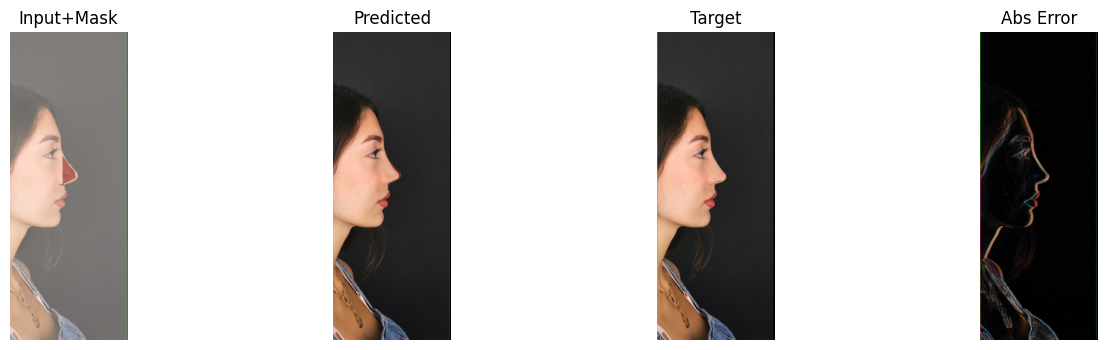

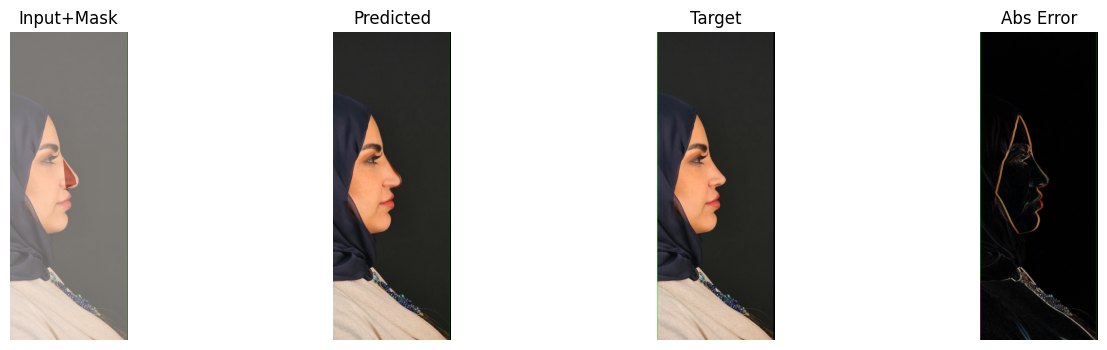

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [31]:
with torch.no_grad():
    pred = G(inp)   # [B,3,H,W]



def show_triplet(rgb, mask, pred, target, idx=0):
    """Show input RGB+mask, predicted, and ground truth."""
    r = rgb[idx].permute(1,2,0).cpu().numpy()
    m = mask[idx,0].cpu().numpy()
    p = pred[idx].permute(1,2,0).clamp(0,1).cpu().numpy()
    t = target[idx].permute(1,2,0).cpu().numpy()

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].imshow(r); axs[0].imshow(m, alpha=0.4, cmap="Reds"); axs[0].set_title("Input+Mask")
    axs[1].imshow(p); axs[1].set_title("Predicted")
    axs[2].imshow(t); axs[2].set_title("Target")
    axs[3].imshow(abs(p-t)); axs[3].set_title("Abs Error")
    for ax in axs: ax.axis("off")
    plt.show()

# show first 3 samples
for i in range(3):
    show_triplet(rgb, mask, pred, target, idx=i)

In [32]:
import torchvision.utils as vutils
vutils.save_image(pred, "pred_samples.png", nrow=4, normalize=True)

In [33]:
import os, torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

# reuse your mask ops
# dilate_mask_binary, feather_mask as previously defined

@torch.no_grad()
def ssim_eval_on_bbox(pred, target, m_soft, ssim_metric, *, thresh=0.05, dilate_px=4):
    B, C, H, W = pred.shape
    vals = []
    for b in range(B):
        mb = m_soft[b, 0]
        yy, xx = (mb > thresh).nonzero(as_tuple=True)
        if yy.numel() == 0:
            pb, tb = pred[b:b+1], target[b:b+1]
        else:
            y0, y1 = yy.min().item(), yy.max().item() + 1
            x0, x1 = xx.min().item(), xx.max().item() + 1
            y0 = max(0, y0 - dilate_px); x0 = max(0, x0 - dilate_px)
            y1 = min(H, y1 + dilate_px); x1 = min(W, x1 + dilate_px)
            pb = pred[b:b+1, :, y0:y1, x0:x1]
            tb = target[b:b+1, :, y0:y1, x0:x1]
        vals.append(ssim_metric(pb.clamp(0,1), tb.clamp(0,1)).item())
    return sum(vals) / max(1, len(vals))

In [34]:
@torch.no_grad()
def run_test(G, test_loader, save_dir="test_outputs", compute_metrics=True, ssim_bbox_dilate=4):
    os.makedirs(save_dir, exist_ok=True)
    # grids subfolder (optional)
    os.makedirs(os.path.join(save_dir, "grids"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "pred"), exist_ok=True)

    if compute_metrics:
        ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(next(G.parameters()).device)
        tot_l1m, tot_ssim_global, tot_ssim_mask, n = 0.0, 0.0, 0.0, 0

    G.eval()
    device = next(G.parameters()).device

    for bi, batch in enumerate(test_loader):
        rgb    = batch["input"].to(device)    # [B,3,H,W] in [0,1]
        target = batch.get("target")
        target = target.to(device) if target is not None else None
        mask   = batch["mask"].to(device)     # [B,1,H,W]
        inp    = torch.cat([rgb, mask], dim=1)

        # forward
        pred = G(inp).clamp(0,1)  # clamp for safe saving/metrics

        # save per-sample predictions
        for i in range(pred.size(0)):
            fname = f"sample_{bi:04d}_{i:02d}.png"
            vutils.save_image(pred[i], os.path.join(save_dir, "pred", fname))

        # make a nice grid: [input, mask overlay, pred, (optional) target, abs err]
        try:
            import matplotlib.pyplot as plt
            import numpy as np
            B = min(rgb.size(0), 4)  # first few
            for i in range(B):
                r = rgb[i].permute(1,2,0).cpu().numpy()
                m = mask[i,0].cpu().numpy()
                p = pred[i].permute(1,2,0).cpu().numpy()
                fig_w = 12 if target is not None else 9
                cols  = 4 if target is not None else 3

                fig, axs = plt.subplots(1, cols, figsize=(fig_w, 3))
                axs[0].imshow(r); axs[0].imshow(m, alpha=0.35, cmap="Reds"); axs[0].set_title("Input+Mask"); axs[0].axis("off")
                axs[1].imshow(p); axs[1].set_title("Predicted"); axs[1].axis("off")

                if target is not None:
                    t = target[i].permute(1,2,0).cpu().numpy()
                    axs[2].imshow(t); axs[2].set_title("Target"); axs[2].axis("off")
                    axs[3].imshow(np.abs(p - t)); axs[3].set_title("Abs Error"); axs[3].axis("off")
                else:
                    axs[2].imshow(m, cmap="gray"); axs[2].set_title("Mask"); axs[2].axis("off")

                fig.tight_layout()
                fig.savefig(os.path.join(save_dir, "grids", f"grid_{bi:04d}_{i:02d}.png"), dpi=150)
                plt.close(fig)
        except Exception:
            # fallback: save a simple grid with torchvision
            grid = torch.cat([rgb[:4], pred[:4]], dim=0)
            vutils.save_image(grid, os.path.join(save_dir, f"grid_{bi:04d}.png"), nrow=4, normalize=False)

        # metrics
        if compute_metrics and (target is not None):
            hard   = dilate_mask_binary(mask, k=11, iters=2)
            m_soft = feather_mask(hard, k=9)

            # L1 over mask
            l1m = ((pred - target).abs() * m_soft).sum() / (m_soft.sum() + 1e-6)
            # SSIM global (clamped already)
            ssim_global = ssim_metric(pred, target)
            # SSIM mask via bbox
            ssim_masked = ssim_eval_on_bbox(pred, target, m_soft, ssim_metric, dilate_px=ssim_bbox_dilate)

            bsz = rgb.size(0)
            tot_l1m        += l1m.item() * bsz
            tot_ssim_global += ssim_global.item() * bsz
            tot_ssim_mask  += ssim_masked * bsz
            n += bsz

    if compute_metrics and n > 0:
        print(f"[TEST] L1(mask)={tot_l1m/n:.4f} | SSIM(global)={tot_ssim_global/n:.4f} | SSIM(mask)={tot_ssim_mask/n:.4f}")

In [35]:
test_ds = NoseFolderDataset(
    "/workspace/data_splits/test/input",
    "/workspace/data_splits/test/mask_input",
    "/workspace/data_splits/test/target"
)

test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=32)
)

run_test(G, test_loader, save_dir="test_outputs_Resv2_test", compute_metrics=True, ssim_bbox_dilate=4)


[validate] counts: img=68 mask=65 target=68
[validate] common triples: 65
[validate] missing masks for 3 imgs, e.g. ['WhatsApp Image 2025-07-12 at 1.36.12 AM (2)', 'WhatsApp Image 2025-07-12 at 5.38.14 PM (1)', 'WhatsApp Image 2025-07-12 at 5.53.22 PM (1)']
[TEST] L1(mask)=0.2795 | SSIM(global)=0.8335 | SSIM(mask)=0.7245


In [57]:
import os, torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

@torch.no_grad()
def compose_hard_overwrite(rgb, full_rgb, mask, k=11, iters=2):
    """Overwrite inside a (possibly dilated) mask; no rim blend."""
    hard  = dilate_mask_binary(mask, k=k, iters=iters).clamp(0,1)
    hard3 = hard.repeat(1,3,1,1)
    return (full_rgb * hard3 + rgb * (1.0 - hard3)).clamp(0,1)

def _save_row(panels, path, dpi=150):
    def to_np(x): return x.detach().clamp(0,1).permute(1,2,0).cpu().numpy()
    fig, axs = plt.subplots(1, len(panels), figsize=(3.0*len(panels), 3.0))
    for j,(title,img) in enumerate(panels):
        axs[j].imshow(to_np(img)); axs[j].set_title(title); axs[j].axis("off")
    fig.tight_layout(); fig.savefig(path, dpi=dpi); plt.close(fig)

@torch.no_grad()
def run_test_compare_variants(
    G, test_loader, *,
    save_dir="test_outputs_compare",
    gamma=1.5,               # residual boost factor for Pred(boost)
    dilate_k=11, dilate_iters=3,  # mask dilation for Pred(dilated)
    compute_metrics=True
):
    os.makedirs(save_dir, exist_ok=True)
    rows_dir = os.path.join(save_dir, "rows"); os.makedirs(rows_dir, exist_ok=True)

    device = next(G.parameters()).device
    G.eval()

    if compute_metrics:
        ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        agg = {k:0. for k in [
            "cur_l1","boost_l1","dil_l1","cur_sg","boost_sg","dil_sg","n"
        ]}

    for bi, batch in enumerate(test_loader):
        rgb    = batch["input"].to(device)                 # [B,3,H,W] in [0,1]
        mask   = batch["mask"].to(device).to(rgb.dtype).clamp(0,1)  # [B,1,H,W]
        inp    = torch.cat([rgb, mask], dim=1)

        # --- base forward (with original mask)
        out_blend, full_rgb, _ = G(inp, return_full=True)
        pred_cur = out_blend.clamp(0,1)

        # --- Pred(boost): amplify residual inside original mask
        delta = full_rgb - rgb
        full_rgb_boost = (rgb + gamma * delta).clamp(0,1)
        pred_boost = compose_hard_overwrite(rgb, full_rgb_boost, mask, k=11, iters=2)

        # --- Pred(dilated): run G with bigger mask, then overwrite with it
        mask_big = dilate_mask_binary(mask, k=dilate_k, iters=dilate_iters).clamp(0,1)
        out_blend_big, full_rgb_big, _ = G(torch.cat([rgb, mask_big], dim=1), return_full=True)
        pred_dilated = compose_hard_overwrite(rgb, full_rgb_big, mask_big, k=11, iters=2)

        # --- per-sample rows
        tgt = batch.get("target"); tgt = tgt.to(device) if tgt is not None else None
        B = rgb.size(0)
        for i in range(B):
            panels = [
                ("Input",          rgb[i]),
                ("Mask",           mask[i].repeat(3,1,1)),
                ("Pred (cur)",     pred_cur[i]),
                (f"Pred (boost x{gamma})", pred_boost[i]),
                (f"Pred (dilated +{dilate_iters})", pred_dilated[i]),
            ]
            if tgt is not None: panels.append(("Target", tgt[i]))
            _save_row(panels, os.path.join(rows_dir, f"sample_{bi:04d}_{i:02d}.png"))

        # --- metrics (masked L1 + global SSIM)
        if compute_metrics and (tgt is not None):
            hard   = dilate_mask_binary(mask, k=11, iters=2)
            m_eval = feather_mask(hard, k=9)
            def l1m(a): return ((a - tgt).abs() * m_eval).sum() / (m_eval.sum() + 1e-6)

            agg["cur_l1"]   += l1m(pred_cur).item()   * B
            agg["boost_l1"] += l1m(pred_boost).item() * B
            agg["dil_l1"]   += l1m(pred_dilated).item()* B
            agg["cur_sg"]   += ssim_metric(pred_cur,   tgt).item()   * B
            agg["boost_sg"] += ssim_metric(pred_boost, tgt).item()   * B
            agg["dil_sg"]   += ssim_metric(pred_dilated, tgt).item() * B
            agg["n"]        += B

    if compute_metrics and agg["n"] > 0:
        n = agg["n"]
        print("[TEST] cur   : L1m={:.4f} | SSIMg={:.4f}".format(agg["cur_l1"]/n,   agg["cur_sg"]/n))
        print("[TEST] boost : L1m={:.4f} | SSIMg={:.4f}".format(agg["boost_l1"]/n, agg["boost_sg"]/n))
        print("[TEST] dilate: L1m={:.4f} | SSIMg={:.4f}".format(agg["dil_l1"]/n,   agg["dil_sg"]/n))

In [58]:
# (optional) give the net more headroom during this test
G.res_max = 1.0

run_test_compare_variants(
    G, test_loader,
    save_dir="test_outputs_compare",
    gamma=1.5,          # try 1.5 first; if subtle, 1.6–1.8
    dilate_k=11, dilate_iters=3,   # grow mask a bit
    compute_metrics=True
)

[TEST] cur   : L1m=0.2919 | SSIMg=0.8331
[TEST] boost : L1m=0.3372 | SSIMg=0.8315
[TEST] dilate: L1m=0.3127 | SSIMg=0.8332


In [60]:
import os, torch
import torch.nn.functional as F
from torchvision.utils import save_image

# ---- helpers: torch <-> numpy, mask prep ----
def _torch_rgb_to_u8_bgr(x: torch.Tensor) -> np.ndarray:
    # x: [3,H,W] float in [0,1]
    x = (x.clamp(0,1) * 255.0).round().byte().cpu().numpy()       # CHW uint8
    x = np.transpose(x, (1,2,0))                                   # HWC
    return cv2.cvtColor(x, cv2.COLOR_RGB2BGR)                      # HWC BGR uint8

def _bgr_u8_to_torch_rgb(x: np.ndarray) -> torch.Tensor:
    # x: HWC BGR uint8
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = torch.from_numpy(np.transpose(x, (2,0,1))).float() / 255.0 # CHW float
    return x

def _mask_to_u8(mask_01: torch.Tensor, thresh=0.05, dilate=3):
    # mask_01: [1,H,W] float in [0,1], soft or hard
    m = (mask_01.squeeze(0).clamp(0,1) > thresh).byte().cpu().numpy() * 255  # H,W uint8 {0,255}
    if dilate and dilate > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*dilate+1, 2*dilate+1))
        m = cv2.dilate(m, k)
    return m  # H,W uint8

def _mask_center(mask_u8: np.ndarray):
    # center for seamlessClone
    M = cv2.moments(mask_u8)
    if M["m00"] > 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        h, w = mask_u8.shape[:2]
        cy, cx = h//2, w//2
    return (cx, cy)

# ---- main: Poisson blend one sample ----
def poisson_blend_sample(pred_rgb, base_rgb, mask_01, mode="normal", dilate=2, thresh=0.3):
    src = _torch_rgb_to_u8_bgr(pred_rgb)   # full repaint
    dst = _torch_rgb_to_u8_bgr(base_rgb)   # original
    msk = _mask_to_u8(mask_01, thresh=thresh, dilate=dilate)  # ~binary 0/255
    center = _mask_center(msk)
    flag = cv2.NORMAL_CLONE if mode=="normal" else cv2.MIXED_CLONE
    out = cv2.seamlessClone(src, dst, msk, center, flag)
    return _bgr_u8_to_torch_rgb(out).to(pred_rgb.device)


def save_triplet_fullsize(rgb_i, pred_i, tgt_i, save_dir, stem):
    os.makedirs(save_dir, exist_ok=True)
    save_image(rgb_i.clamp(0,1),  os.path.join(save_dir, f"{stem}_input.png"))
    save_image(pred_i.clamp(0,1), os.path.join(save_dir, f"{stem}_pred.png"))
    save_image(tgt_i.clamp(0,1),  os.path.join(save_dir, f"{stem}_target.png"))

def pad_to_square(img, value=0.0):  # img: [3,H,W]
    _, H, W = img.shape
    S = max(H, W)
    pad_t = (S - H)//2; pad_b = S - H - pad_t
    pad_l = (S - W)//2; pad_r = S - W - pad_l
    return F.pad(img, (pad_l, pad_r, pad_t, pad_b), value=value)  # [3,S,S]

@torch.no_grad()
def run_test_unet(
    ckpt_path,
    test_loader,
    device="cuda",
    save_dir="results_unet",
    panel_mode="none",          # "none" or "letterbox"
    panel_size=512,             # used only when panel_mode="letterbox"
    amp=True
):
    os.makedirs(save_dir, exist_ok=True)

    # Build UNet exactly like in training
    G = UNetNoseGenerator(in_ch=4, out_ch=3, base=64, depth=5, res_max=0.75).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    G.load_state_dict(ckpt["G"], strict=True)
    G.eval()

    idx = 0
    autocast_ctx = torch.amp.autocast('cuda', enabled=amp)

    for batch in test_loader:
        rgb  = batch["input"].to(device)    # [B,3,Ht,Wt] (padded)
        mask = batch["mask"].to(device)     # [B,1,Ht,Wt]
        tgt  = batch["target"].to(device)   # [B,3,Ht,Wt]
        ohw  = batch.get("orig_hw", None)   # [B,2] if using keep-aspect collate

        inp = torch.cat([rgb, mask], dim=1) # [B,4,Ht,Wt]

        with autocast_ctx:
             out_masked, full_rgb, m_soft = G(inp, return_full=True)                   # [B,3,Ht,Wt]

        B = full_rgb.size(0)
        for i in range(B):
            # crop back to each sample's original H,W (or current if not provided)
            if ohw is not None:
                H, W = int(ohw[i,0]), int(ohw[i,1])
            else:
                _, H, W = rgb[i].shape
            rgb_i         = rgb[i, :, :H, :W]
            tgt_i         = tgt[i,  :, :H, :W]
            pred_masked_i = out_masked[i, :, :H, :W]
            pred_full_i = full_rgb[i, :, :H, :W]
            soft_i        = m_soft[i, :, :H, :W]   # absolute repaint (for Poisson)
            '''  # masked blend (optional)
            pred_i = pred[i, :, :H, :W]
            tgt_i  = tgt[i,  :, :H, :W]
            rgb_i  = rgb[i,  :, :H, :W]
            mask_i = mask[i, :, :H, :W]

            hard   = dilate_mask_binary(mask_i.unsqueeze(0), k=21, iters=3).squeeze(0) 
            soft   = feather_mask(hard.unsqueeze(0), k=15).squeeze(0)
            '''
            #blended_i = poisson_blend_sample(pred_rgb=pred_i, base_rgb=rgb_i, mask_01=soft, mode="normal", dilate=2, thresh=0.05)
            blended_i = poisson_blend_sample(
            pred_rgb=pred_full_i,
            base_rgb=rgb_i,
            mask_01=soft_i,         # internally thresholded & slightly dilated
            mode="normal",
            dilate=2,
            thresh=0.3              # a bit higher than 0.05 → crisper mask
            )
            stem = f"{idx:05d}"
            save_image(pred_masked_i.clamp(0,1), os.path.join(save_dir, f"{stem}_pred_masked.png"))
            save_image(pred_full_i.clamp(0,1),   os.path.join(save_dir, f"{stem}_pred_full.png"))
            save_image(blended_i.clamp(0,1),     os.path.join(save_dir, f"{stem}_pred_blended.png"))
            save_triplet_fullsize(rgb_i, pred_masked_i, tgt_i, save_dir, stem)  # input/masked/targe                             
            
            # 1) always save full-size triplet (no stretch)
            #save_triplet_fullsize(rgb_i, pred_i, tgt_i, save_dir, stem)

            # 2) optional preview panel (letterboxed, not stretched)
            if panel_mode == "letterbox":
                tiles = [pad_to_square(x.clamp(0,1)) for x in (rgb_i, pred_i, tgt_i)]
                # (optional) downscale large squares for disk space
                if panel_size is not None:
                    tiles = [F.interpolate(t.unsqueeze(0), size=(panel_size, panel_size),
                                            mode="bilinear", align_corners=False).squeeze(0)
                             for t in tiles]
                row = torch.stack(tiles, dim=0)  # [3,3,S,S]
                save_image(row, os.path.join(save_dir, f"{stem}_panel.png"), nrow=3)

            idx += 1

In [61]:
test_ds = NoseFolderDataset(
    "/workspace/data_splits/val/input",
    "/workspace/data_splits/val/mask_input",
    "/workspace/data_splits/val/target"
)

from torch.utils.data import DataLoader
test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True,
    persistent_workers=False,
    collate_fn=lambda b: collate_keep_aspect(b, multiple=32)
)

run_test_unet(
    ckpt_path="ckpts_Unet_PatchGan_Resv1/best_l1_mask.pt",
    test_loader=test_loader,
    device=device,
    save_dir="/workspace/results_unet_v3.1_postprocess",
    
    panel_size=256,
    amp=True
)

[validate] counts: img=67 mask=63 target=67
[validate] common triples: 63
[validate] missing masks for 4 imgs, e.g. ['WhatsApp Image 2025-07-12 at 5.46.30 PM', 'WhatsApp Image 2025-07-12 at 5.46.31 PM (2)', 'WhatsApp Image 2025-07-12 at 5.53.17 PM (1)', 'WhatsApp Image 2025-07-12 at 6.20.03 PM']
